In [ ]:
!pip install tensorflow

In [2]:
import os, zipfile, random, shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, applications, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, accuracy_score
from collections import Counter

In [3]:
image_size=(244,244)

In [5]:
import zipfile, shutil, os
from pathlib import Path

# Define paths
DATA_ROOT = Path("./data_extracted_fixed")
train_dir=r"/content/train-20251104T055344Z-1-001.zip"
val_dir=r"/content/valid-20251104T055346Z-1-001.zip"
test_dir=r"/content/test-20251104T055346Z-1-001.zip"

# Clean old extraction if exists
if DATA_ROOT.exists():
    shutil.rmtree(DATA_ROOT)
DATA_ROOT.mkdir(parents=True, exist_ok=True)

def smart_extract(zip_path, target_dir):
    """Extract zip and automatically detect the actual 'train/valid/test' folder level."""
    print(f"Extracting {zip_path} ...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
    print(f"Extracted to {target_dir}")

    # Find the real dataset folder (contains class subfolders)
    # e.g., /data/train/train/...  or /data/train/...
    candidates = list(Path(target_dir).rglob("train"))
    if not candidates:
        candidates = list(Path(target_dir).rglob("Train"))
    if candidates:
        print(f"Found train folder candidate: {candidates[0]}")
    return target_dir

# Extract all datasets
smart_extract(train_dir, DATA_ROOT / "train")
smart_extract(val_dir, DATA_ROOT / "valid")
smart_extract(test_dir,  DATA_ROOT / "test")

# Detect the deepest actual directories that contain class folders
def find_actual_dataset_dir(base_dir):
    base_dir = Path(base_dir)
    subdirs = [p for p in base_dir.rglob("*") if p.is_dir() and any(f.suffix.lower() in ['.jpg', '.jpeg', '.png'] for f in p.glob("*"))]
    if subdirs:
        # Return parent folder containing class folders
        parents = {p.parent for p in subdirs}
        best = min(parents, key=lambda p: len(p.parts))
        print(f"✅ Found valid dataset directory: {best}")
        return best
    else:
        print(f"⚠️ No images found under {base_dir}, check your zip structure.")
        return base_dir

TRAIN_DIR = find_actual_dataset_dir(DATA_ROOT / "train")
VALID_DIR = find_actual_dataset_dir(DATA_ROOT / "valid")
TEST_DIR  = find_actual_dataset_dir(DATA_ROOT / "test")

print(f"\nFinal dataset directories:")
print(f"Train dir: {TRAIN_DIR}")
print(f"Valid dir: {VALID_DIR}")
print(f"Test dir:  {TEST_DIR}")

# Quick verification
for root, dirs, files in os.walk(TRAIN_DIR):
    print(f"\nSample structure check:\n{root} -> {len(dirs)} class folders")
    print("Classes:", dirs)
    break



Extracting /content/train-20251104T055344Z-1-001.zip ...
Extracted to data_extracted_fixed/train
Found train folder candidate: data_extracted_fixed/train/train
Extracting /content/valid-20251104T055346Z-1-001.zip ...
Extracted to data_extracted_fixed/valid
Extracting /content/test-20251104T055346Z-1-001.zip ...
Extracted to data_extracted_fixed/test
✅ Found valid dataset directory: data_extracted_fixed/train/train
✅ Found valid dataset directory: data_extracted_fixed/valid/valid
✅ Found valid dataset directory: data_extracted_fixed/test/test

Final dataset directories:
Train dir: data_extracted_fixed/train/train
Valid dir: data_extracted_fixed/valid/valid
Test dir:  data_extracted_fixed/test/test

Sample structure check:
data_extracted_fixed/train/train -> 4 class folders
Classes: ['meningioma', 'no_tumor', 'glioma', 'pituitary']


In [6]:

SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_ROOT = Path("data_extracted_fixed")
TRAIN_DIR = DATA_ROOT / "train" / "train"
VALID_DIR = DATA_ROOT / "valid" / "valid"
TEST_DIR  = DATA_ROOT / "test" / "test"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10
OUTPUT_DIR = Path("models_outputs")
OUTPUT_DIR.mkdir(exist_ok=True)

In [7]:
def create_dataset(directory, img_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory,
        labels="inferred",
        label_mode="int",
        batch_size=batch_size,
        image_size=img_size,
        shuffle=shuffle,
        seed=SEED,
        color_mode="rgb"   # ❠ Force 3-channel RGB to avoid grayscale mismatch
    )
    return ds

train_ds = create_dataset(TRAIN_DIR)
val_ds   = create_dataset(VALID_DIR, shuffle=False)
test_ds  = create_dataset(TEST_DIR, shuffle=False)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)


# ❠ Sanity check: verify image shape

# ❠ Sanity check: verify image shape
for images, labels in train_ds.take(1):
    print(f"Sample image batch shape: {images.shape}")
    print(f"Sample label batch shape: {labels.shape}")

# Normalize pixel values to [0–1]
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

# Prefetch for better performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1695 files belonging to 4 classes.
Found 502 files belonging to 4 classes.
Found 246 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary']
Sample image batch shape: (32, 224, 224, 3)
Sample label batch shape: (32,)


In [8]:
print("✅ Setting up augmentation...")
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.15),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomContrast(0.1)
], name="data_augmentation")


✅ Setting up augmentation...


In [9]:
# ---- Custom CNN ----
def build_custom_cnn(input_shape=(224,224,3), num_classes=4):
    model = models.Sequential([
        data_augmentation,
        layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.4),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

custom_cnn = build_custom_cnn((224,224,3), num_classes)
custom_cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
custom_cnn.summary()

# ---- Transfer Learning Models ----
def build_transfer_model(base_model, num_classes=4):
    base_model.trainable = False
    inputs = layers.Input(shape=(224,224,3))
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs)
    return model

transfer_models = {
    "ResNet50": build_transfer_model(applications.ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "MobileNetV2": build_transfer_model(applications.MobileNetV2(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
    "InceptionV3": build_transfer_model(applications.InceptionV3(weights="imagenet", include_top=False, input_shape=(224,224,3)), num_classes),
}

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step



Training CustomCNN ...
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4201 - loss: 1.6209

53/53 ━━━━━━━━━━━━━━━━━━━━ 325s 6s/step - accuracy: 0.4214 - loss: 1.6168 - val_accuracy: 0.3207 - val_loss: 1.3457
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 307s 6s/step - accuracy: 0.5727 - loss: 1.1443 - val_accuracy: 0.3207 - val_loss: 1.4339
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 309s 6s/step - accuracy: 0.5987 - loss: 1.1019 - val_accuracy: 0.3207 - val_loss: 1.6849
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 324s 6s/step - accuracy: 0.6182 - loss: 1.0651 - val_accuracy: 0.3227 - val_loss: 1.8350
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 302s 6s/step - accuracy: 0.6477 - loss: 1.0156 - val_accuracy: 0.3327 - val_loss: 1.8524


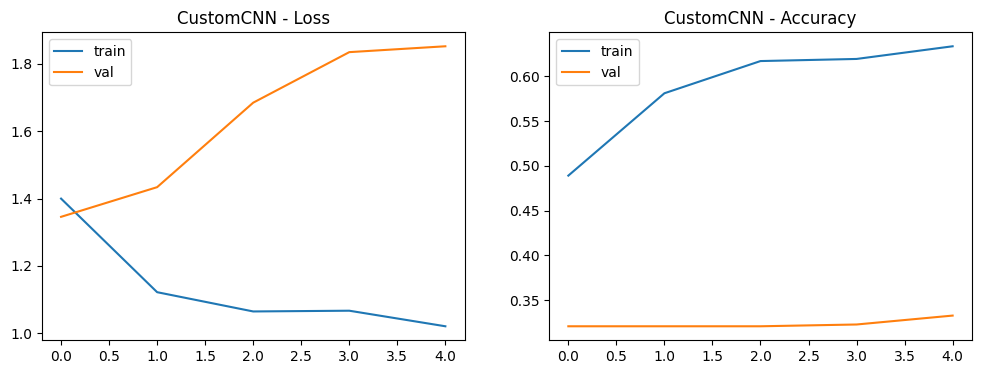


Training ResNet50 ...
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2484 - loss: 1.7494

53/53 ━━━━━━━━━━━━━━━━━━━━ 373s 7s/step - accuracy: 0.2485 - loss: 1.7477 - val_accuracy: 0.3187 - val_loss: 1.3875
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2941 - loss: 1.4556

53/53 ━━━━━━━━━━━━━━━━━━━━ 374s 7s/step - accuracy: 0.2941 - loss: 1.4557 - val_accuracy: 0.3386 - val_loss: 1.3513
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2911 - loss: 1.4821

53/53 ━━━━━━━━━━━━━━━━━━━━ 380s 7s/step - accuracy: 0.2913 - loss: 1.4818 - val_accuracy: 0.3486 - val_loss: 1.3418
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2964 - loss: 1.4539

53/53 ━━━━━━━━━━━━━━━━━━━━ 364s 7s/step - accuracy: 0.2965 - loss: 1.4537 - val_accuracy: 0.3845 - val_loss: 1.3310
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3320 - loss: 1.4241

53/53 ━━━━━━━━━━━━━━━━━━━━ 373s 7s/step - accuracy: 0.3318 - loss: 1.4240 - val_accuracy: 0.3944 - val_loss: 1.3192
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3246 - loss: 1.3931

53/53 ━━━━━━━━━━━━━━━━━━━━ 356s 7s/step - accuracy: 0.3248 - loss: 1.3931 - val_accuracy: 0.3984 - val_loss: 1.3049
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3454 - loss: 1.3721

53/53 ━━━━━━━━━━━━━━━━━━━━ 381s 7s/step - accuracy: 0.3450 - loss: 1.3724 - val_accuracy: 0.4183 - val_loss: 1.2984
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3331 - loss: 1.3837

53/53 ━━━━━━━━━━━━━━━━━━━━ 383s 7s/step - accuracy: 0.3332 - loss: 1.3836 - val_accuracy: 0.4143 - val_loss: 1.2864
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3215 - loss: 1.3751

53/53 ━━━━━━━━━━━━━━━━━━━━ 364s 7s/step - accuracy: 0.3216 - loss: 1.3750 - val_accuracy: 0.4203 - val_loss: 1.2799
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3523 - loss: 1.3622

53/53 ━━━━━━━━━━━━━━━━━━━━ 373s 7s/step - accuracy: 0.3522 - loss: 1.3623 - val_accuracy: 0.4183 - val_loss: 1.2702


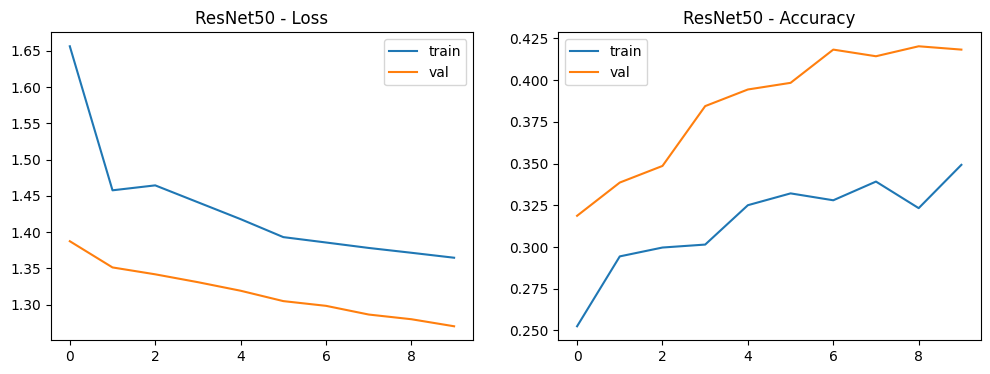


Training MobileNetV2 ...
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3029 - loss: 1.6503

53/53 ━━━━━━━━━━━━━━━━━━━━ 110s 2s/step - accuracy: 0.3036 - loss: 1.6481 - val_accuracy: 0.2908 - val_loss: 1.4869
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4322 - loss: 1.3248

53/53 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.4326 - loss: 1.3238 - val_accuracy: 0.3904 - val_loss: 1.3072
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5165 - loss: 1.1437

53/53 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.5166 - loss: 1.1433 - val_accuracy: 0.4781 - val_loss: 1.1750
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6054 - loss: 0.9866

53/53 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6053 - loss: 0.9867 - val_accuracy: 0.5259 - val_loss: 1.1023
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6147 - loss: 0.9375

53/53 ━━━━━━━━━━━━━━━━━━━━ 104s 2s/step - accuracy: 0.6144 - loss: 0.9379 - val_accuracy: 0.5637 - val_loss: 1.0183
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6078 - loss: 0.9099

53/53 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.6083 - loss: 0.9094 - val_accuracy: 0.5717 - val_loss: 0.9732
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6639 - loss: 0.8445

53/53 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6639 - loss: 0.8442 - val_accuracy: 0.5976 - val_loss: 0.9346
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6818 - loss: 0.8029

53/53 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step - accuracy: 0.6819 - loss: 0.8030 - val_accuracy: 0.6175 - val_loss: 0.9049
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7037 - loss: 0.7643

53/53 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.7036 - loss: 0.7641 - val_accuracy: 0.6255 - val_loss: 0.8580
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7237 - loss: 0.7176

53/53 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.7234 - loss: 0.7178 - val_accuracy: 0.6414 - val_loss: 0.8412


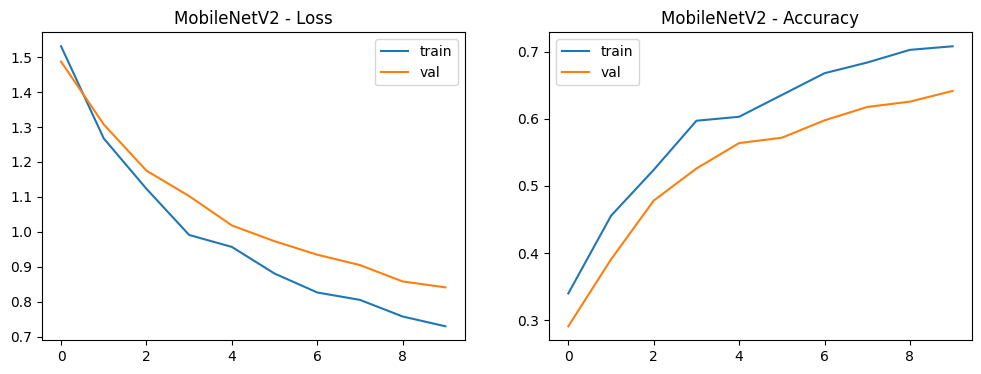


Training InceptionV3 ...
Epoch 1/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3256 - loss: 1.4569

53/53 ━━━━━━━━━━━━━━━━━━━━ 265s 5s/step - accuracy: 0.3267 - loss: 1.4556 - val_accuracy: 0.4781 - val_loss: 1.2163
Epoch 2/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4668 - loss: 1.2296

53/53 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.4671 - loss: 1.2292 - val_accuracy: 0.5498 - val_loss: 1.0933
Epoch 3/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5414 - loss: 1.0946

53/53 ━━━━━━━━━━━━━━━━━━━━ 253s 5s/step - accuracy: 0.5414 - loss: 1.0945 - val_accuracy: 0.5817 - val_loss: 0.9953
Epoch 4/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6116 - loss: 0.9611

53/53 ━━━━━━━━━━━━━━━━━━━━ 291s 5s/step - accuracy: 0.6114 - loss: 0.9610 - val_accuracy: 0.6135 - val_loss: 0.9212
Epoch 5/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6154 - loss: 0.9520

53/53 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.6155 - loss: 0.9514 - val_accuracy: 0.6155 - val_loss: 0.9006
Epoch 6/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6638 - loss: 0.8631

53/53 ━━━━━━━━━━━━━━━━━━━━ 262s 5s/step - accuracy: 0.6637 - loss: 0.8630 - val_accuracy: 0.6633 - val_loss: 0.8286
Epoch 7/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6858 - loss: 0.8264

53/53 ━━━━━━━━━━━━━━━━━━━━ 292s 5s/step - accuracy: 0.6860 - loss: 0.8261 - val_accuracy: 0.6614 - val_loss: 0.8082
Epoch 8/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6845 - loss: 0.8028

53/53 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.6844 - loss: 0.8028 - val_accuracy: 0.6753 - val_loss: 0.8026
Epoch 9/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6922 - loss: 0.7655

53/53 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.6924 - loss: 0.7651 - val_accuracy: 0.6773 - val_loss: 0.7972
Epoch 10/10
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7165 - loss: 0.7251

53/53 ━━━━━━━━━━━━━━━━━━━━ 253s 5s/step - accuracy: 0.7163 - loss: 0.7255 - val_accuracy: 0.7032 - val_loss: 0.7517


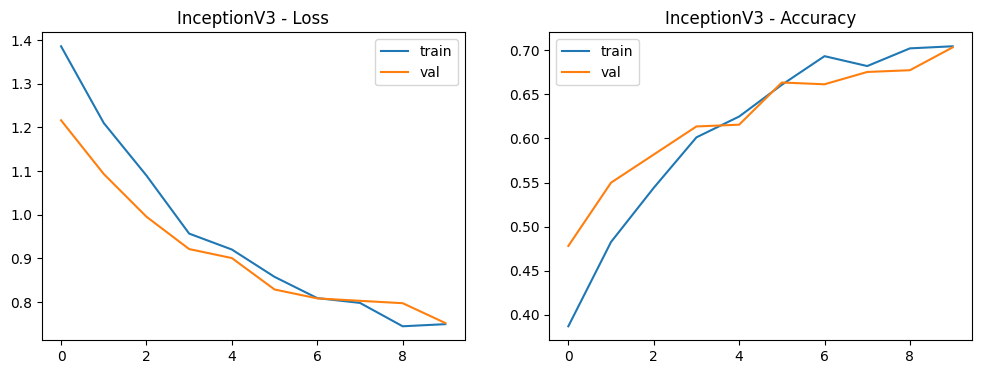

In [10]:
results = []

def train_model(model, name):
    print(f"\nTraining {name} ...")
    cb = [
        callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
        callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/{name}_best.h5", save_best_only=True)
    ]
    model.compile(optimizer=optimizers.Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=cb)
    # Plot history
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.title(f'{name} - Loss'); plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='val')
    plt.title(f'{name} - Accuracy'); plt.legend()
    plt.show()
    return model, history

# Train Custom CNN
custom_cnn, history_cnn = train_model(custom_cnn, "CustomCNN")

# Train Transfer Models
for name, model in transfer_models.items():
    model, hist = train_model(model, name)
    transfer_models[name] = model

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


📊 CustomCNN Results:
Accuracy=0.3252  Precision=0.1062  Recall=0.3252  F1=0.1601
              precision    recall  f1-score   support

      glioma       0.33      1.00      0.49        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.00      0.00      0.00        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.33       246
   macro avg       0.08      0.25      0.12       246
weighted avg       0.11      0.33      0.16       246



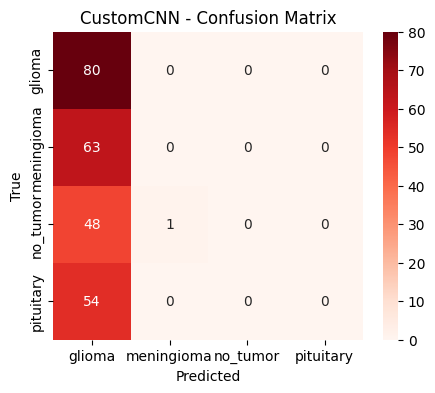


📊 ResNet50 Results:
Accuracy=0.4146  Precision=0.2764  Recall=0.4146  F1=0.2890
              precision    recall  f1-score   support

      glioma       0.37      1.00      0.54        80
  meningioma       0.00      0.00      0.00        63
    no_tumor       0.79      0.45      0.57        49
   pituitary       0.00      0.00      0.00        54

    accuracy                           0.41       246
   macro avg       0.29      0.36      0.28       246
weighted avg       0.28      0.41      0.29       246



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

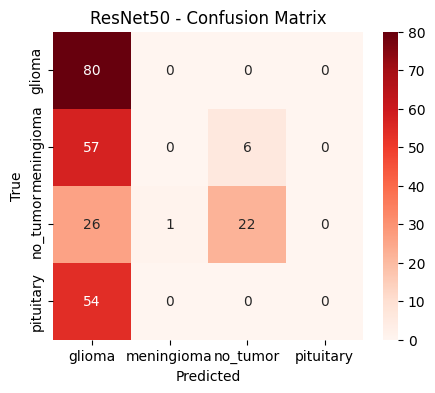


📊 MobileNetV2 Results:
Accuracy=0.6667  Precision=0.6918  Recall=0.6667  F1=0.6670
              precision    recall  f1-score   support

      glioma       0.83      0.62      0.71        80
  meningioma       0.58      0.60      0.59        63
    no_tumor       0.72      0.59      0.65        49
   pituitary       0.59      0.87      0.70        54

    accuracy                           0.67       246
   macro avg       0.68      0.67      0.66       246
weighted avg       0.69      0.67      0.67       246



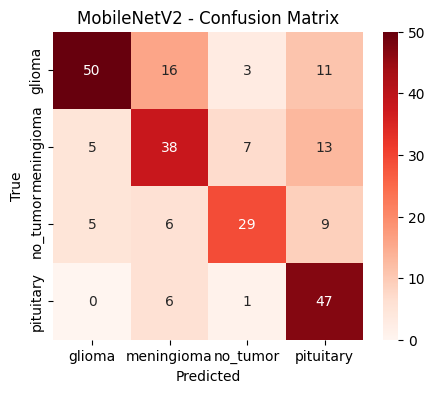


📊 InceptionV3 Results:
Accuracy=0.6504  Precision=0.6839  Recall=0.6504  F1=0.6273
              precision    recall  f1-score   support

      glioma       0.74      0.76      0.75        80
  meningioma       0.65      0.24      0.35        63
    no_tumor       0.83      0.69      0.76        49
   pituitary       0.50      0.93      0.65        54

    accuracy                           0.65       246
   macro avg       0.68      0.66      0.63       246
weighted avg       0.68      0.65      0.63       246



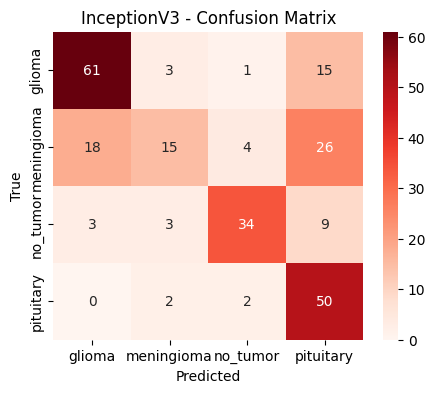

In [11]:
def evaluate_model(model, name):
    y_true, y_pred = [], []
    for imgs, labels in test_ds:
        preds = model.predict(imgs, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    print(f"\n📊 {name} Results:")
    print(f"Accuracy={acc:.4f}  Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")
    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()
    return {"model": name, "accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

# Evaluate all models
results.append(evaluate_model(custom_cnn, "CustomCNN"))
for name, model in transfer_models.items():
    results.append(evaluate_model(model, name))

